### Livrable 1 - Montrer l'accès et le traitement des données d'une base MongoDB via Python sous Jupyter

<u>Salle 113, groupe composé de</u> : 
- Brayan **BIOUT**
- Thierry **BISSEL**
- Donovan **HOANG**
- Théophile **MONTEMONT**
- Thomas **SCHUBNEL**

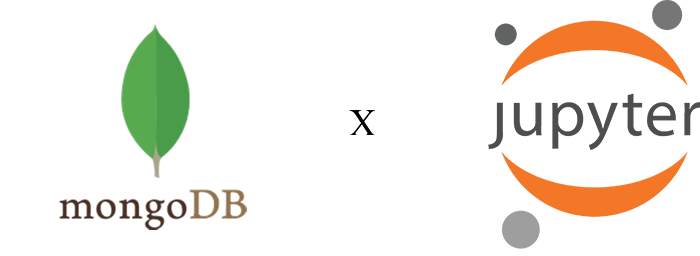

L'objectif de ce livrable est d'installer l'environement nécessaire au projet et de realiser le traitement des données d'une base MongoDB via Python. <br>
Ceci ce fait grace a l'installation de bibliothèques qui sont les suivantes :
<br>
- ***pymongo*** : pymongo est une bibliothèque Python contenant des outils pour travailler avec MongoDB et est la méthode recommandée pour travailler avec MongoDB à partir de Python. Pymongo est ce qu’on appelle un « Driver » python pour MongoDB, c'est-à-dire un programme client qui permet aux applications python d’accéder à une base de données MongoDB.
- ***pretty print*** : prettyprint est une bibliothèque qui effectue le processus de conversion et de présentation du code source ou d'autres objets de manière lisible et attrayante. Un prettyprinter prend des blocs de code et les imprime de manière esthétique, en présentant les caractères avec des sauts de ligne et des indentations pour rendre le code compréhensible.


#### Partie 1 - Connexion à la base de données
Dans la partie suivante nous allons voir comment ce connecter à la base de données MongoDB et ainsi recupérer un premier jeu de données.

In [1]:
# Import de pymongo et pprint
from pymongo import MongoClient
import pprint

# Création du client qui se connecte à la base de données 'DataProject'
client = MongoClient('localhost', 27017)
db = client['DataProject']

# Récuperation de la collection véhicules de la base de données
collection_trafic = db['vehicules']
print()
# Affichage le nombre de documents de la collection.
# Nous utilisons la fonction count_documents({}) tandis que la fonction count() est dépréciée
print("Le nombre de document dans la collection vehicules est de : " + str(collection_trafic.count_documents({})))


Le nombre de document dans la collection vehicules est de : 600000


#### Partie 2 - Traitement des données d'une base MongoDB
Dans la partie suivante, nous allons voir comment traiter les donnée de la base MongoDB selon l'énoncé de la séquence 0.
Cette séquence a pour but de convertir les données dans la collection 'vehicules' vers une nouvelle collection 'vehicules_stamped' en remplaçant les propriétées "num_jour", "plage_horaire" et "num_periode" par une propriété unique date au format {jour}/{mois}/{année} {heures}h{minutes}m .

Une étape de validation permettra d'assurer la cohérence des donnée traitée ainsi que la vérification de la conversion

In [2]:
from pymongo import MongoClient
import pprint
import datetime
import time
import re

client = MongoClient('localhost', 27017)
db = client['DataProject']
vehicules = db['vehicules']

vehicules_stamped = db['vehicules_stamped']


def convert(num_jour, plage_horaire, num_periode):
    return datetime.datetime(2020,
                            1,
                            num_jour + 1,
                            (7 if plage_horaire == "m" else 17) + num_periode //60,
                             num_periode%60
                             ).strftime("%d/%m/%Y %Hh%Mm")
#converting collection

if(True):
    vehicules_stamped.delete_many({})

    data_stamped = []
    for trafic in vehicules.find() :
        
        data_stamped.append({
            "num_arete" : trafic["num_arete"],
            "date" : convert(trafic["num_jour"],trafic["plage_horaire"], trafic["num_periode"]),
            "nb_vehicules" : trafic["nb_vehicules"]})
        
    vehicules_stamped.insert_many(list(data_stamped))

## validation part
print ("\nExpected rows : ")
print(vehicules.count_documents({}))
print ("\nCounted rows : ")
print(vehicules_stamped.count_documents({}))

print("\nDatetime display : \n")
pprint.pprint(list(vehicules_stamped.find({},{"_id" : 0, "date" : 1})[0:5]))

print("\nVehicule per time period expected : ")
vehicules_par_plage = {"m":0, "s":0}
for trafic in vehicules.find({"$or":[{"plage_horaire":"m"}, {"plage_horaire":"s"}]}):
    plage = trafic["plage_horaire"]
    vehicules_par_plage[plage] += trafic["nb_vehicules"]
print(vehicules_par_plage)

print("\nVehicule per time period recieved : ")
vehicules_par_plage_s = {"m":0, "s":0}
for trafic in vehicules_stamped.find():
    plage = "m" if re.match(".+ 0+[7-9]h.+",trafic["date"]) else "s"
    vehicules_par_plage_s[plage] += trafic["nb_vehicules"]
print(vehicules_par_plage_s)


Expected rows : 
600000

Counted rows : 
600000

Datetime display : 

[{'date': '01/01/2020 07h02m'},
 {'date': '01/01/2020 07h00m'},
 {'date': '01/01/2020 07h04m'},
 {'date': '01/01/2020 07h05m'},
 {'date': '01/01/2020 07h06m'}]

Vehicule per time period expected : 
{'m': 19720247, 's': 28191853}

Vehicule per time period recieved : 
{'m': 19720247, 's': 28191853}
